## Load Data

In [18]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import BatchNormalization

In [19]:
data = pd.read_csv('predicting_food_crises_data.csv')
data = data.dropna()
data = data.reset_index(drop=True)
# Create column for food crisis defined by IPC of 3 or more
def crisis(row):
  if row['fews_ipc'] <= 2:
    return 0
  elif row['fews_ipc'] > 2:
    return 1
 
data['food_crisis'] = data.apply (lambda row: crisis(row), axis=1)


Train Test Split with Stratified K fold

In [20]:
from sklearn.model_selection import StratifiedKFold

X = data.loc[:, data.columns != 'food_crisis']
y = data.loc[:, data.columns == 'food_crisis']
X =  data[['centx', 'centy',
       'year', 'month',  'fews_ha', 'ndvi_mean',
       'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean', 'et_anom',
       'acled_count', 'acled_fatalities', 'p_staple_food', 'area',
       'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct']]
#Transformations
X['log_pop'] = np.log(X['pop'])
X['log_ruggedness'] = np.log(X['ruggedness_mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [21]:
from sklearn.preprocessing import MinMaxScaler
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=44)

month = train_X['month']
year = train_X['year']
fews = train_X['fews_ha']
train_X_mean = train_X.mean()
train_X_std = train_X.std()
train_X = (train_X - train_X_mean)/train_X_std
train_X['fews_ha'] = fews
train_X['month'] = month
train_X['year'] = year
train_X['food_crisis'] = train_y

month = test_X['month']
year = test_X['year']
fews = test_X['fews_ha']
test_X_mean = test_X.mean()
test_X_std = test_X.std()
test_X = (test_X - test_X_mean)/test_X_std
test_X['fews_ha'] = fews
test_X['month'] = month
test_X['year'] = year
test_X['food_crisis'] = test_y


In [24]:
test_X.describe()

,centx,centy,year,month,fews_ha,ndvi_mean,ndvi_anom,rain_mean,rain_anom,et_mean,et_anom,acled_count,acled_fatalities,p_staple_food,area,cropland_pct,pop,ruggedness_mean,pasture_pct,log_pop,log_ruggedness,food_crisis
count,9.672000e+03,9.672000e+03,9672.000000,9672.000000,9672.000000,9.672000e+03,9.672000e+03,9.672000e+03,9.672000e+03,9.672000e+03,9.672000e+03,9.672000e+03,9.672000e+03,9.672000e+03,9.672000e+03,9.672000e+03,9.672000e+03,9.672000e+03,9.672000e+03,9.672000e+03,9.672000e+03,9672.000000
mean,-4.336688e-15,-4.729605e-15,2015.492866,5.744210,0.069272,5.431116e-15,-9.272704e-15,4.553498e-16,3.975085e-17,4.129072e-15,6.814177e-16,-1.822191e-16,6.688485e-16,-2.418483e-16,-4.295445e-15,-1.622665e-15,7.472669e-16,5.574130e-15,-1.325400e-14,-3.141350e-15,5.194677e-14,0.153639
std,1.000000e+00,1.000000e+00,2.318402,3.284705,0.253929,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.360621
min,-3.747474e+00,-2.797683e+00,2012.000000,1.000000,0.000000,-2.070412e+00,-5.538588e+01,-7.874708e-01,-5.630400e+00,-1.009931e+00,-4.357616e+00,-2.032885e-01,-1.452473e-01,-3.054451e-01,-4.976884e-01,-1.164343e+00,-5.709492e-01,-7.625458e-01,-1.931448e+00,-4.236591e+00,-2.658927e+00,0.000000
25%,-2.997152e-01,-4.921474e-01,2014.000000,2.000000,0.000000,-8.978199e-01,-2.037733e-01,-7.426660e-01,-2.819432e-01,-8.999071e-01,-4.124452e-01,-2.032885e-01,-1.452473e-01,-2.237842e-01,-4.105106e-01,-8.793934e-01,-4.429908e-01,-6.265899e-01,-7.622418e-01,-6.757863e-01,-6.915846e-01,0.000000
50%,3.259242e-01,2.532388e-01,2015.000000,6.000000,0.000000,-1.670498e-01,-2.489627e-02,-4.637737e-01,-1.166325e-01,-3.832084e-01,-1.622772e-01,-2.032885e-01,-1.452473e-01,-1.953181e-01,-2.814239e-01,-2.176360e-01,-3.244803e-01,-4.029910e-01,1.093979e-01,-1.023229e-01,1.202267e-02,0.000000
75%,5.114909e-01,5.934074e-01,2017.000000,10.000000,0.000000,9.143490e-01,1.572522e-01,4.806354e-01,1.210105e-01,8.410597e-01,3.040064e-01,-2.032885e-01,-1.452473e-01,-1.256842e-01,-1.322152e-02,6.073307e-01,-2.652413e-02,2.008523e-01,7.749153e-01,5.956936e-01,7.477158e-01,0.000000
max,1.701551e+00,2.559771e+00,2020.000000,10.000000,1.000000,2.233717e+00,5.674781e+01,6.762821e+00,9.174926e+00,3.289368e+00,7.009667e+00,2.745318e+01,2.800508e+01,1.532720e+01,1.178434e+01,2.593982e+00,1.166572e+01,7.885553e+00,1.821825e+00,3.351483e+00,2.410217e+00,1.000000


# Model

Tensorflow Feature Layer

In [25]:
#title Run on TensorFlow 2.x
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

In [26]:

# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent Latitude.
lat = tf.feature_column.numeric_column("centx")
feature_columns.append(lat)

# Create a numerical feature column to represent Longitude.
lon = tf.feature_column.numeric_column("centy")
feature_columns.append(lon)

# Create a numerical feature column to represent fews_ha.
fews_ha = tf.feature_column.numeric_column("fews_ha")
feature_columns.append(fews_ha)

# Create a numerical feature column to represent ndvi_mean.
ndvi_mean = tf.feature_column.numeric_column("ndvi_mean")
feature_columns.append(ndvi_mean)

# Create a numerical feature column to represent rain_mean.
rain_mean = tf.feature_column.numeric_column("rain_mean")
feature_columns.append(rain_mean)

# # Create a numerical feature column to represent et_mean.
# et_mean = tf.feature_column.numeric_column("et_mean")
# feature_columns.append(et_mean)

# Create a numerical feature column to represent acled_count.
acled_count = tf.feature_column.numeric_column("acled_count")
feature_columns.append(acled_count)

# # Create a numerical feature column to represent acled_fatalities.
# acled_fatalities = tf.feature_column.numeric_column("acled_fatalities")
# feature_columns.append(acled_fatalities)

# Create a numerical feature column to represent p_staple_food.
p_staple_food = tf.feature_column.numeric_column("p_staple_food")
feature_columns.append(p_staple_food)

# Create a numerical feature column to represent area.
area = tf.feature_column.numeric_column("area")
feature_columns.append(area)

# Create a numerical feature column to represent p_staple_food.
cropland_pct = tf.feature_column.numeric_column("cropland_pct")
feature_columns.append(cropland_pct)

# Create a numerical feature column to represent month.
month = tf.feature_column.numeric_column("month")
feature_columns.append(month)

# Create a numerical feature column to represent pop.
pop = tf.feature_column.numeric_column("log_pop")
feature_columns.append(pop)

# Create a numerical feature column to represent ruggedness_mean.
ruggedness_mean = tf.feature_column.numeric_column("log_ruggedness")
feature_columns.append(ruggedness_mean)

# Create a numerical feature column to pasture_pct.
pasture_pct = tf.feature_column.numeric_column("pasture_pct")
feature_columns.append(pasture_pct)

# # Create a numerical feature column to represent ndvi_anom.
# ndvi_anom = tf.feature_column.numeric_column("ndvi_anom")
# feature_columns.append(ndvi_anom)

# # Create a numerical feature column to represent rain_anom.
# rain_anom = tf.feature_column.numeric_column("rain_anom")
# feature_columns.append(rain_anom)

# # Create a numerical feature column to represent et_anom.
# et_anom = tf.feature_column.numeric_column("et_anom")
# feature_columns.append(et_anom)


# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_X))

<tf.Tensor: shape=(19635, 13), dtype=float32, numpy=
array([[-0.20950094, -0.45364863,  0.5129278 , ..., -0.04046097,
        -1.2208818 , -0.2956594 ],
       [-0.20950094, -0.3901069 , -0.50219107, ..., -0.25925305,
         1.143357  , -0.78979236],
       [-0.20950094, -0.21651664,  0.04936969, ..., -0.2006841 ,
         0.12569205, -0.7681358 ],
       ...,
       [-0.20950094, -0.31043914,  0.21764515, ..., -0.22671376,
         0.22003011, -0.69034874],
       [-0.20950094, -0.24388921, -0.08569734, ..., -0.27746415,
         1.2559098 ,  1.0520777 ],
       [-0.20950094, -0.26710203, -0.59116095, ..., -0.23209134,
        -0.95661426,  0.24197826]], dtype=float32)>

Model

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00077: early stopping


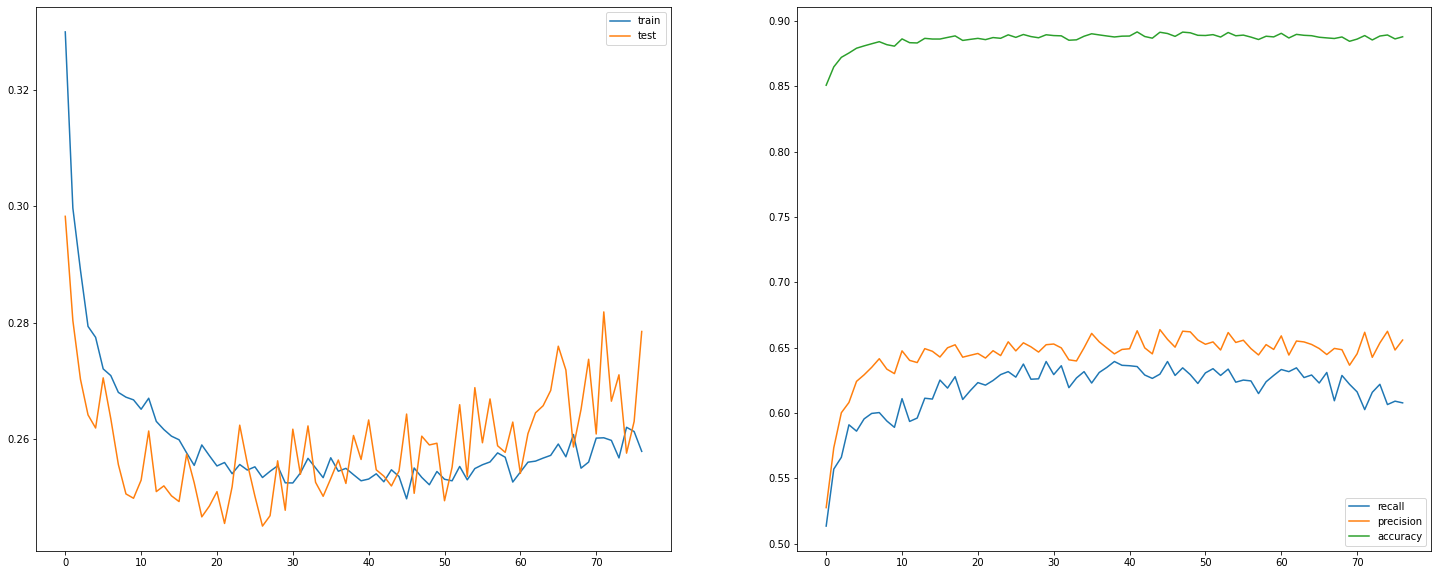

In [ ]:
classification_threshold = .30


features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))

model = tf.keras.models.Sequential()
model.add(feature_layer)
model.add(BatchNormalization())
model.add(layers.Dense(150, activation='relu'))  
model.add(layers.Dense(150, activation='relu'))  
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                    activation=tf.sigmoid),)
  # Establish the metrics the model will measure.
METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr = 0.001),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 50)
history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs=1000, verbose=0, callbacks=[es])


# plot training history
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (25, 10))

ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='test')
ax1.legend()
ax2.plot(history.history['recall'], label = 'recall')
ax2.plot(history.history['precision'], label = 'precision')
ax2.plot(history.history['accuracy'], label = 'accuracy')
ax2.legend()

# Model Evaluation

In [ ]:
features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))
model.evaluate(x = features_test, y = label_test)

303/303 [==============================] - 0s 2ms/step - loss: 0.2785 - accuracy: 0.8970 - precision: 0.7080 - recall: 0.5612


[0.2784871757030487,
 0.8970223069190979,
 0.7079796195030212,
 0.5612382292747498]

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(features_test).flatten() > classification_threshold

print(predictions)


cm = confusion_matrix(y_true=label_test, y_pred=predictions)

print(cm)

from sklearn.metrics import classification_report
print(classification_report(label_test, predictions))

[False False False ... False False False]
[[7591  595]
 [ 425 1061]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      8186
           1       0.64      0.71      0.68      1486

    accuracy                           0.89      9672
   macro avg       0.79      0.82      0.81      9672
weighted avg       0.90      0.89      0.90      9672



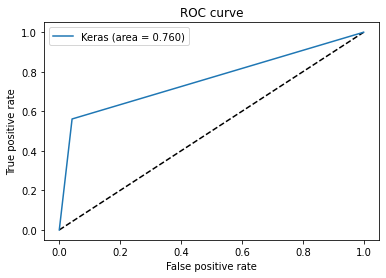

In [ ]:
from sklearn.metrics import roc_curve

# y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_test, predictions)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

#Hyperparameter Sweeps

Training Iterations with RMSprop

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


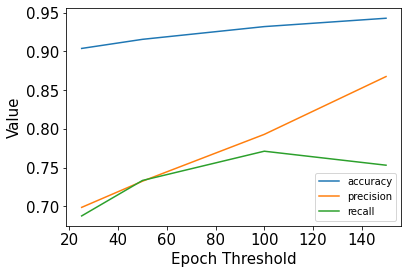

In [ ]:
epochs_to_try = [25, 50, 100, 150]
classification_threshold = .30
ACC_list = []
PREC_list = []
RECALL_list = []



features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))

model = tf.keras.models.Sequential()
model.add(feature_layer)
model.add(layers.Dense(150, activation='relu'))  
model.add(layers.Dense(150, activation='relu'))  
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                    activation=tf.sigmoid),)
  # Establish the metrics the model will measure.
METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)


for epochs in epochs_to_try:

  history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs=epochs, verbose=0)


    
  x=history.history['accuracy']
  x=x[len(x)-1] #  last element is the final value
  ACC_list.append(x)  

  y=history.history['precision']
  y=y[len(y)-1] #  last element is the final value
  PREC_list.append(y)

  z=history.history['recall']
  z=z[len(z)-1] #  last element is the final value
  RECALL_list.append(z)


plt.figure()
plt.xlabel("Epoch Threshold", fontsize = 15)
plt.ylabel("Value", fontsize = 15)

plt.plot(epochs_to_try, ACC_list, label='accuracy')
plt.plot(epochs_to_try, PREC_list, label='precision')
plt.plot(epochs_to_try, RECALL_list, label='recall')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()



elbow occurs around 75 epoch afterwards training value decreases

## Learning Rate with RMS prop

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00929: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00098: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00101: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00079: early stopping


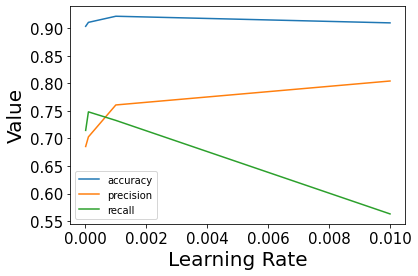

In [ ]:
classification_threshold = .30
ACC_list = []
PREC_list = []
RECALL_list = []


features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))

model = tf.keras.models.Sequential()
model.add(feature_layer)
model.add(layers.Dense(150, activation='relu'))  
model.add(layers.Dense(150, activation='relu'))  
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                    activation=tf.sigmoid),)
  # Establish the metrics the model will measure.
METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]
lr_to_try = [0.00001, 0.0001, 0.001, 0.01]
for lr in lr_to_try:
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=lr),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)
  


  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 75)
  history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs=1000, verbose=0, callbacks=[es])
 
  x=history.history['accuracy']
  x=x[len(x)-1] #  last element is the final value
  ACC_list.append(x)  

  y=history.history['precision']
  y=y[len(y)-1] #  last element is the final value
  PREC_list.append(y)

  z=history.history['recall']
  z=z[len(z)-1] #  last element is the final value
  RECALL_list.append(z)
      

plt.figure()
plt.xlabel("Learning Rate", fontsize = 20)
plt.ylabel("Value", fontsize = 20)

plt.plot(lr_to_try, ACC_list, label='accuracy')
plt.plot(lr_to_try, PREC_list, label='precision')
plt.plot(lr_to_try, RECALL_list, label='recall')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()

## Epochs with Adam 

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


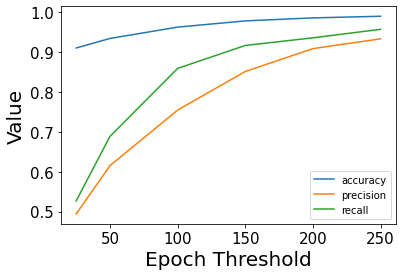

In [ ]:
epochs_to_try = [25, 50, 100, 150, 200, 250]
classification_threshold = .30
ACC_list = []
PREC_list = []
RECALL_list = []



features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))

model = tf.keras.models.Sequential()
model.add(feature_layer)
model.add(layers.Dense(150, activation='relu'))  
model.add(layers.Dense(150, activation='relu'))  
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                    activation=tf.sigmoid),)
  # Establish the metrics the model will measure.
METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)


for epochs in epochs_to_try:

  history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs=epochs, verbose=0)


    
  x=history.history['accuracy']
  x=x[len(x)-1] #  last element is the final value
  ACC_list.append(x)  

  y=history.history['precision']
  y=y[len(y)-1] #  last element is the final value
  PREC_list.append(y)

  z=history.history['recall']
  z=z[len(z)-1] #  last element is the final value
  RECALL_list.append(z)


plt.figure()
plt.xlabel("Epoch Threshold", fontsize = 20)
plt.ylabel("Value", fontsize = 20)

plt.plot(epochs_to_try, ACC_list, label='accuracy')
plt.plot(epochs_to_try, PREC_list, label='precision')
plt.plot(epochs_to_try, RECALL_list, label='recall')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.legend()



Training value starts to decrease around 200 epochs

Classification Threshold

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00189: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00183: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00181: early stopping


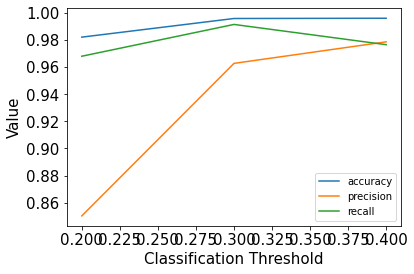

In [ ]:

ACC_list = []
PREC_list = []
RECALL_list = []



features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))

model = tf.keras.models.Sequential()
model.add(feature_layer)
model.add(layers.Dense(150, activation='relu'))  
model.add(layers.Dense(150, activation='relu'))  
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                    activation=tf.sigmoid),)
  # Establish the metrics the model will measure.
classification_threshold_to_try = [0.2, .3, .4] 
for classification_threshold in classification_threshold_to_try:
  METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]

  model.compile(optimizer=tf.keras.optimizers.Adam(),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)
  


  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 175)
  history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs=1000, verbose=0, callbacks=[es])
 
  x=history.history['accuracy']
  x=x[len(x)-1] #  last element is the final value
  ACC_list.append(x)  

  y=history.history['precision']
  y=y[len(y)-1] #  last element is the final value
  PREC_list.append(y)

  z=history.history['recall']
  z=z[len(z)-1] #  last element is the final value
  RECALL_list.append(z)
      



plt.figure( figsize=(15,15))
plt.xlabel("Classification Threshold", fontsize = 15)
plt.ylabel("Value", fontsize = 15)

plt.plot(classification_threshold_to_try, ACC_list, label='accuracy')
plt.plot(classification_threshold_to_try, PREC_list, label='precision')
plt.plot(classification_threshold_to_try, RECALL_list, label='recall')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()

Number of Neurons

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00281: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00222: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00215: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00195: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00191: early stopping


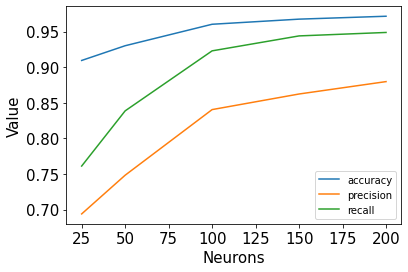

In [ ]:
ACC_list = []
PREC_list = []
RECALL_list = []

classification_threshold = .30

features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))
neurons_to_try = [25, 50, 100, 150, 200]
for neuron in neurons_to_try:
  model = tf.keras.models.Sequential()
  model.add(feature_layer)
  model.add(layers.Dense(neuron, activation='relu'))  
  model.add(layers.Dense(neuron, activation='relu'))  
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                      activation=tf.sigmoid),)
  # Establish the metrics the model will measure.

  METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]

  model.compile(optimizer=tf.keras.optimizers.Adam(),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)
  


  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 175)
  history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs=1000, verbose=0, callbacks=[es])
  
  x=history.history['accuracy']
  x=x[len(x)-1] #  last element is the final value
  ACC_list.append(x)  

  y=history.history['precision']
  y=y[len(y)-1] #  last element is the final value
  PREC_list.append(y)

  z=history.history['recall']
  z=z[len(z)-1] #  last element is the final value
  RECALL_list.append(z)
      
  


plt.figure()
plt.xlabel("Neurons", fontsize = 15)
plt.ylabel("Value", fontsize = 15)

plt.plot(neurons_to_try, ACC_list, label='accuracy')
plt.plot(neurons_to_try, PREC_list, label='precision')
plt.plot(neurons_to_try, RECALL_list, label='recall')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()

Neurons in first layer

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00249: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00212: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00206: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00197: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00197: early stopping


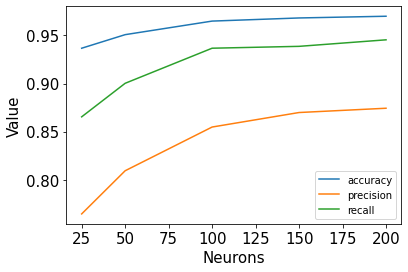

In [ ]:
ACC_list = []
PREC_list = []
RECALL_list = []

classification_threshold = .30

features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))
neurons_to_try = [25, 50, 100, 150, 200]
for neuron in neurons_to_try:
  model = tf.keras.models.Sequential()
  model.add(feature_layer)
  model.add(layers.Dense(neuron, activation='relu'))  
  model.add(layers.Dense(150, activation='relu'))  
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                      activation=tf.sigmoid),)
  # Establish the metrics the model will measure.

  METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]

  model.compile(optimizer=tf.keras.optimizers.Adam(),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)
  


  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 175)
  history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs=1000, verbose=0, callbacks=[es])
  
  x=history.history['accuracy']
  x=x[len(x)-1] #  last element is the final value
  ACC_list.append(x)  

  y=history.history['precision']
  y=y[len(y)-1] #  last element is the final value
  PREC_list.append(y)

  z=history.history['recall']
  z=z[len(z)-1] #  last element is the final value
  RECALL_list.append(z)
      
  


plt.figure()
plt.xlabel("Neurons", fontsize = 15)
plt.ylabel("Value", fontsize = 15)

plt.plot(neurons_to_try, ACC_list, label='accuracy')
plt.plot(neurons_to_try, PREC_list, label='precision')
plt.plot(neurons_to_try, RECALL_list, label='recall')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()

neurons in second layer

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00227: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00210: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00197: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00204: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00202: early stopping


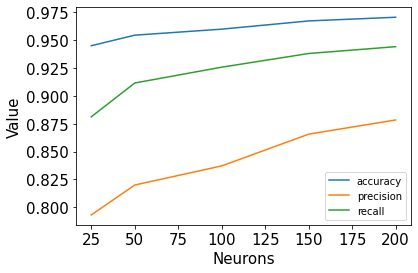

In [ ]:
ACC_list = []
PREC_list = []
RECALL_list = []

classification_threshold = .30

features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))
neurons_to_try = [25, 50, 100, 150, 200]
for neuron in neurons_to_try:
  model = tf.keras.models.Sequential()
  model.add(feature_layer)
  model.add(layers.Dense(150, activation='relu'))  
  model.add(layers.Dense(neuron, activation='relu'))  
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                      activation=tf.sigmoid),)
  # Establish the metrics the model will measure.

  METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]

  model.compile(optimizer=tf.keras.optimizers.Adam(),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)
  


  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 175)
  history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs=1000, verbose=0, callbacks=[es])
  
  x=history.history['accuracy']
  x=x[len(x)-1] #  last element is the final value
  ACC_list.append(x)  

  y=history.history['precision']
  y=y[len(y)-1] #  last element is the final value
  PREC_list.append(y)

  z=history.history['recall']
  z=z[len(z)-1] #  last element is the final value
  RECALL_list.append(z)
      
  


plt.figure()
plt.xlabel("Neurons", fontsize = 15)
plt.ylabel("Value", fontsize = 15)

plt.plot(neurons_to_try, ACC_list, label='accuracy')
plt.plot(neurons_to_try, PREC_list, label='precision')
plt.plot(neurons_to_try, RECALL_list, label='recall')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()

One hidden layer

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00790: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00660: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00286: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00330: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00279: early stopping


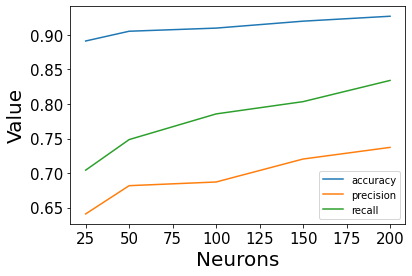

In [ ]:
ACC_list = []
PREC_list = []
RECALL_list = []

classification_threshold = .30

features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))
neurons_to_try = [25, 50, 100, 150, 200]
for neuron in neurons_to_try:
  model = tf.keras.models.Sequential()
  model.add(feature_layer)
  model.add(layers.Dense(neuron, activation='relu'))  
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                      activation=tf.sigmoid),)
  # Establish the metrics the model will measure.

  METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]

  model.compile(optimizer=tf.keras.optimizers.Adam(),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)
  


  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 175)
  history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs=1000, verbose=0, callbacks=[es])
  
  x=history.history['accuracy']
  x=x[len(x)-1] #  last element is the final value
  ACC_list.append(x)  

  y=history.history['precision']
  y=y[len(y)-1] #  last element is the final value
  PREC_list.append(y)

  z=history.history['recall']
  z=z[len(z)-1] #  last element is the final value
  RECALL_list.append(z)
      
  


plt.figure()
plt.xlabel("Neurons", fontsize = 20)
plt.ylabel("Value", fontsize = 20)

plt.plot(neurons_to_try, ACC_list, label='accuracy')
plt.plot(neurons_to_try, PREC_list, label='precision')
plt.plot(neurons_to_try, RECALL_list, label='recall')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00223: early stopping
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


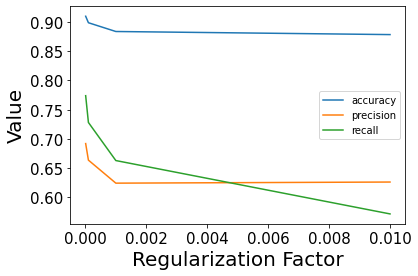

In [ ]:
from tensorflow.keras import regularizers
ACC_list = []
PREC_list = []
RECALL_list = []

classification_threshold = .30
regularizers_to_try = [0.00001, 0.0001, 0.001, 0.01]

features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))

for reg in regularizers_to_try:
  model = tf.keras.models.Sequential()
  model.add(feature_layer)
  model.add(BatchNormalization())
  model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(reg)))  
  model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(reg)))  
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                      activation=tf.sigmoid),)
    # Establish the metrics the model will measure.
  METRICS = [
            tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                            threshold=classification_threshold),
            tf.keras.metrics.Precision(thresholds=classification_threshold,
                                      name='precision' 
                                      ),
            tf.keras.metrics.Recall(thresholds=classification_threshold,
                                    name="recall"),
      ]
  model.compile(optimizer=tf.keras.optimizers.Adam(),                                                   
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=METRICS)

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 175)
  history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs=300, verbose=0, callbacks=[es])

    
  x=history.history['accuracy']
  x=x[len(x)-1] #  last element is the final value
  ACC_list.append(x)  

  y=history.history['precision']
  y=y[len(y)-1] #  last element is the final value
  PREC_list.append(y)

  z=history.history['recall']
  z=z[len(z)-1] #  last element is the final value
  RECALL_list.append(z)


plt.figure()
plt.xlabel("Regularization Factor", fontsize = 20)
plt.ylabel("Value", fontsize = 20)

plt.plot(regularizers_to_try, ACC_list, label='accuracy')
plt.plot(regularizers_to_try, PREC_list, label='precision')
plt.plot(regularizers_to_try, RECALL_list, label='recall')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()



regularizers

## Full Model W/O Regularization

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00227: early stopping


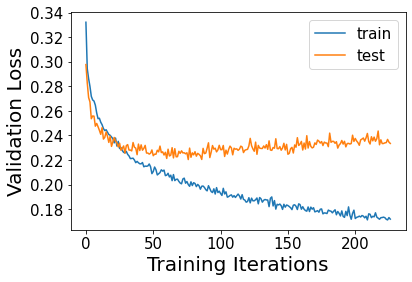

In [27]:
from tensorflow.keras import regularizers
classification_threshold = .30


features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))

model = tf.keras.models.Sequential()
model.add(feature_layer)
model.add(BatchNormalization())
model.add(layers.Dense(200, activation='relu'))  
model.add(layers.Dense(200, activation='relu'))  
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                    activation=tf.sigmoid),)
  # Establish the metrics the model will measure.
METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]
model.compile(optimizer=tf.keras.optimizers.Adam(),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)



es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 150)
history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs= 500, verbose=0, callbacks=[es])


# plot training history
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Training Iterations',fontsize = 20)
plt.ylabel('Validation Loss', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)

In [28]:
features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))
model.evaluate(x = features_test, y = label_test)

303/303 [==============================] - 1s 2ms/step - loss: 0.2335 - accuracy: 0.8849 - precision: 0.5988 - recall: 0.7604


[0.23352888226509094,
 0.8849255442619324,
 0.5988341569900513,
 0.7604306936264038]

In [29]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(features_test).flatten() > classification_threshold

print(predictions)


cm = confusion_matrix(y_true=label_test, y_pred=predictions)

print(cm)

from sklearn.metrics import classification_report
print(classification_report(label_test, predictions))

Consider rewriting this model with the Functional API.
[False False False ... False False False]
[[7429  757]
 [ 356 1130]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      8186
           1       0.60      0.76      0.67      1486

    accuracy                           0.88      9672
   macro avg       0.78      0.83      0.80      9672
weighted avg       0.90      0.88      0.89      9672



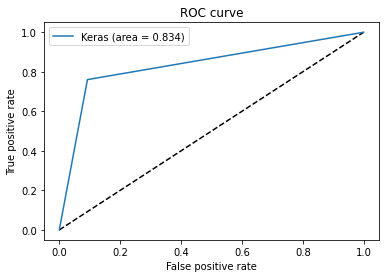

In [30]:
from sklearn.metrics import roc_curve

# y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_test, predictions)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Full Model with Regularization

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00345: early stopping


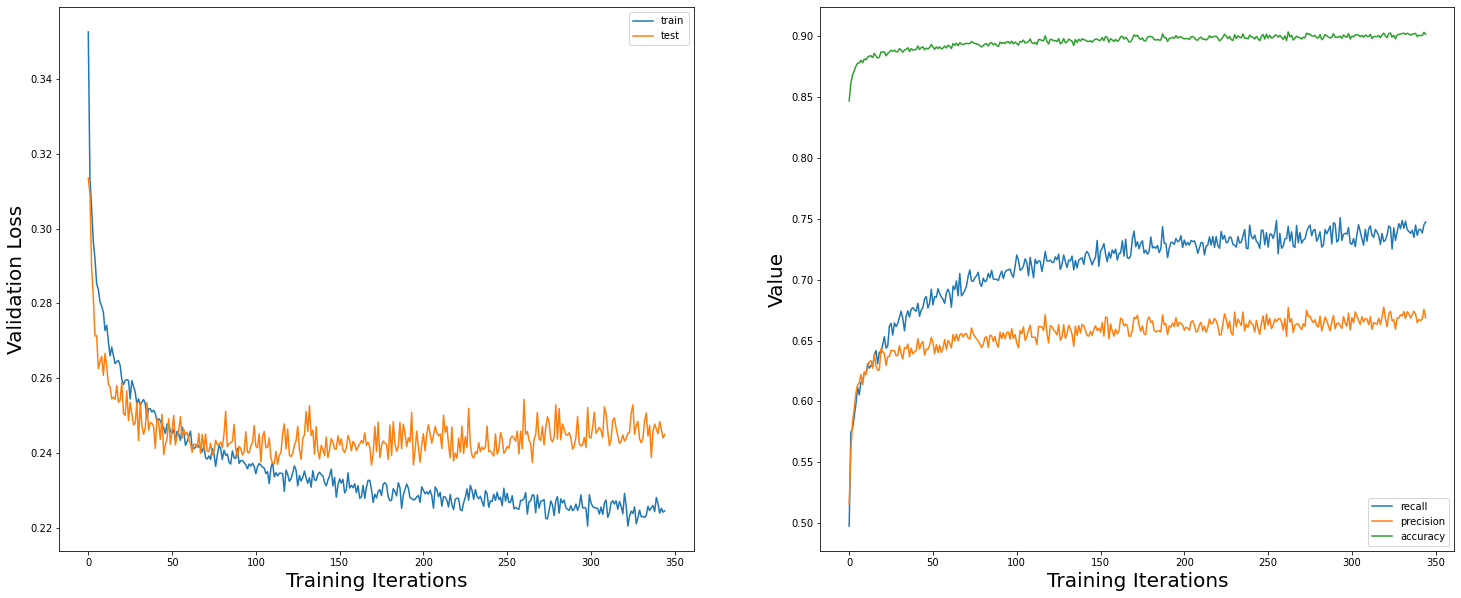

In [ ]:
from tensorflow.keras import regularizers
classification_threshold = .30


features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))

model = tf.keras.models.Sequential()
model.add(feature_layer)
model.add(BatchNormalization())
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))  
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))  
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                    activation=tf.sigmoid),)
  # Establish the metrics the model will measure.
METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]
model.compile(optimizer=tf.keras.optimizers.Adam(),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)



es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 175)
history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs= 500, verbose=0, callbacks=[es])


# plot training history
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (25, 10))

ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='test')
ax1.legend()
ax2.plot(history.history['recall'], label = 'recall')
ax2.plot(history.history['precision'], label = 'precision')
ax2.plot(history.history['accuracy'], label = 'accuracy')
ax1.set_xlabel('Training Iterations',fontsize = 20)
ax1.set_ylabel('Validation Loss', fontsize = 20)
ax2.set_xlabel('Training Iterations',fontsize = 20)
ax2.set_ylabel('Value', fontsize = 20)
ax2.legend()

In [ ]:
features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))
model.evaluate(x = features_test, y = label_test)

303/303 [==============================] - 0s 2ms/step - loss: 0.2450 - accuracy: 0.8945 - precision: 0.6407 - recall: 0.7140


[0.244985431432724, 0.8945409655570984, 0.6407004594802856, 0.7139973044395447]

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(features_test).flatten() > classification_threshold

print(predictions)


cm = confusion_matrix(y_true=label_test, y_pred=predictions)

print(cm)

from sklearn.metrics import classification_report
print(classification_report(label_test, predictions))

Consider rewriting this model with the Functional API.
[False False False ... False False False]
[[7591  595]
 [ 425 1061]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      8186
           1       0.64      0.71      0.68      1486

    accuracy                           0.89      9672
   macro avg       0.79      0.82      0.81      9672
weighted avg       0.90      0.89      0.90      9672



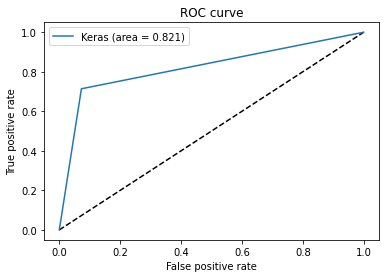

In [ ]:
from sklearn.metrics import roc_curve

# y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_test, predictions)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Regulization, set patience to 150 

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00432: early stopping


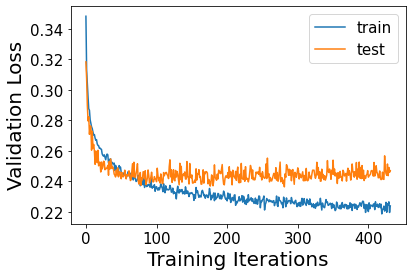

In [31]:
from tensorflow.keras import regularizers
classification_threshold = .30


features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))

model = tf.keras.models.Sequential()
model.add(feature_layer)
model.add(BatchNormalization())
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))  
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))  
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                    activation=tf.sigmoid),)
  # Establish the metrics the model will measure.
METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]
model.compile(optimizer=tf.keras.optimizers.Adam(),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)



es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 150)
history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs= 500, verbose=0, callbacks=[es])


# plot training history

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Training Iterations',fontsize = 20)
plt.ylabel('Validation Loss', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)

In [32]:
features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))
model.evaluate(x = features_test, y = label_test)

303/303 [==============================] - 1s 2ms/step - loss: 0.2470 - accuracy: 0.8849 - precision: 0.6022 - recall: 0.7396


[0.2469957023859024,
 0.8849255442619324,
 0.6021918058395386,
 0.7395693063735962]

In [33]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(features_test).flatten() > classification_threshold

print(predictions)


cm = confusion_matrix(y_true=label_test, y_pred=predictions)

print(cm)

from sklearn.metrics import classification_report
print(classification_report(label_test, predictions))

Consider rewriting this model with the Functional API.
[False False  True ...  True False False]
[[7460  726]
 [ 387 1099]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      8186
           1       0.60      0.74      0.66      1486

    accuracy                           0.88      9672
   macro avg       0.78      0.83      0.80      9672
weighted avg       0.90      0.88      0.89      9672



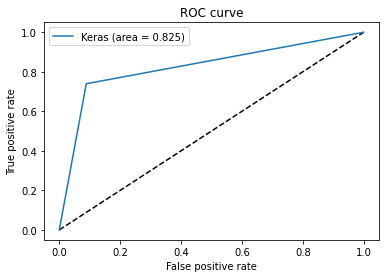

In [34]:
from sklearn.metrics import roc_curve

# y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_test, predictions)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Optimize Recall

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00238: early stopping


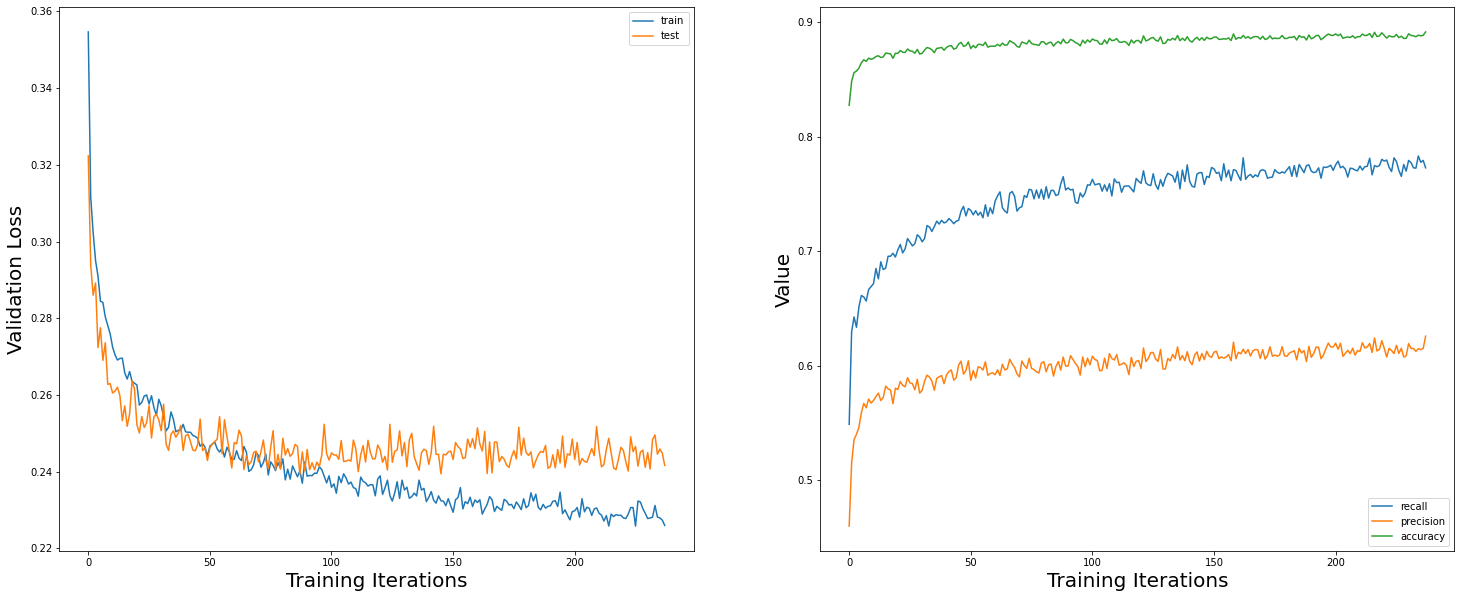

In [ ]:
from tensorflow.keras import regularizers
classification_threshold = .25


features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))

model = tf.keras.models.Sequential()
model.add(feature_layer)
model.add(BatchNormalization())
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))  
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))  
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                    activation=tf.sigmoid),)
  # Establish the metrics the model will measure.
METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]
model.compile(optimizer=tf.keras.optimizers.Adam(),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)



es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 150)
history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs= 500, verbose=0, callbacks=[es])


# plot training history
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (25, 10))

ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='test')
ax1.legend()
ax2.plot(history.history['recall'], label = 'recall')
ax2.plot(history.history['precision'], label = 'precision')
ax2.plot(history.history['accuracy'], label = 'accuracy')
ax1.set_xlabel('Training Iterations',fontsize = 20)
ax1.set_ylabel('Validation Loss', fontsize = 20)
ax2.set_xlabel('Training Iterations',fontsize = 20)
ax2.set_ylabel('Value', fontsize = 20)
ax2.legend()

In [ ]:
features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))
model.evaluate(x = features_test, y = label_test)

303/303 [==============================] - 1s 2ms/step - loss: 0.2416 - accuracy: 0.8700 - precision: 0.5550 - recall: 0.7773


[0.24164123833179474,
 0.8700371980667114,
 0.5550216436386108,
 0.7772544026374817]

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(features_test).flatten() > classification_threshold

print(predictions)


cm = confusion_matrix(y_true=label_test, y_pred=predictions)

print(cm)

from sklearn.metrics import classification_report
print(classification_report(label_test, predictions))

Consider rewriting this model with the Functional API.
[False False False ... False False False]
[[7260  926]
 [ 331 1155]]
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      8186
           1       0.56      0.78      0.65      1486

    accuracy                           0.87      9672
   macro avg       0.76      0.83      0.78      9672
weighted avg       0.89      0.87      0.88      9672



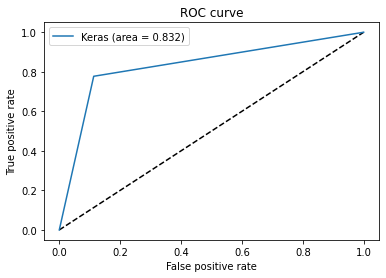

In [ ]:
from sklearn.metrics import roc_curve

# y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_test, predictions)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Optimize Precision

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Epoch 00081: early stopping


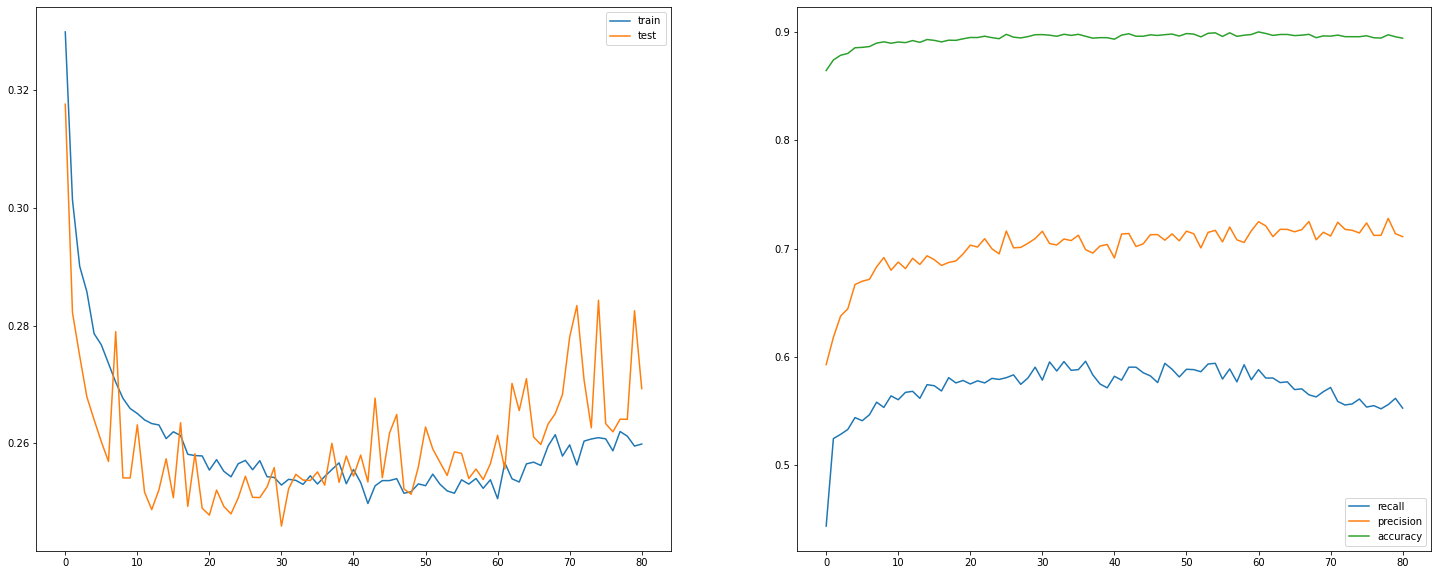

In [ ]:
classification_threshold = .35


features_train = {name:np.array(value) for name, value in train_X.items()}
label_train = np.array(features_train.pop('food_crisis')) 

features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))

model = tf.keras.models.Sequential()
model.add(feature_layer)
model.add(BatchNormalization())
model.add(layers.Dense(150, activation='relu'))  
model.add(layers.Dense(150, activation='relu'))  
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                    activation=tf.sigmoid),)
  # Establish the metrics the model will measure.
METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                          threshold=classification_threshold),
          tf.keras.metrics.Precision(thresholds=classification_threshold,
                                    name='precision' 
                                    ),
          tf.keras.metrics.Recall(thresholds=classification_threshold,
                                  name="recall"),
    ]
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr = 0.001),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 50)
history = model.fit(x = features_train, y = label_train, validation_data=(features_test, label_test), epochs=1000, verbose=0, callbacks=[es])


# plot training history
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (25, 10))

ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='test')
ax1.legend()
ax2.plot(history.history['recall'], label = 'recall')
ax2.plot(history.history['precision'], label = 'precision')
ax2.plot(history.history['accuracy'], label = 'accuracy')
ax2.legend()

In [ ]:
features_test = {name:np.array(value) for name, value in test_X.items()}
label_test = np.array(features_test.pop('food_crisis'))
model.evaluate(x = features_test, y = label_test)

303/303 [==============================] - 0s 2ms/step - loss: 0.2693 - accuracy: 0.8970 - precision: 0.6845 - recall: 0.6117


[0.2692601978778839,
 0.8970223069190979,
 0.6844879388809204,
 0.6117092967033386]

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(features_test).flatten() > classification_threshold

print(predictions)


cm = confusion_matrix(y_true=label_test, y_pred=predictions)

print(cm)

from sklearn.metrics import classification_report
print(classification_report(label_test, predictions))

[False False False ... False False False]
[[7767  419]
 [ 577  909]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      8186
           1       0.68      0.61      0.65      1486

    accuracy                           0.90      9672
   macro avg       0.81      0.78      0.79      9672
weighted avg       0.89      0.90      0.89      9672



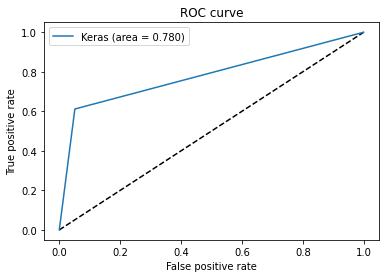

In [ ]:
from sklearn.metrics import roc_curve

# y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_test, predictions)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [39]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from numpy import random
rand_predictions=random.randint(1, size=(9672))